### Objective

The dataset contains house sales from year 2007 to 2019. And our objective is to build a model to predict the sales on future years.

### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import calendar
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.api import seasonal_decompose
import statsmodels.tsa.api as smt
import itertools
import sys
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

### Loading the Dataset

In [2]:
df=pd.read_csv('house_sales.csv',parse_dates=['datesold'])
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3


#### Printing datatypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datesold      29580 non-null  datetime64[ns]
 1   postcode      29580 non-null  int64         
 2   price         29580 non-null  int64         
 3   propertyType  29580 non-null  object        
 4   bedrooms      29580 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


#### Checking the catagorical values in property datatype

In [4]:
df['propertyType'].value_counts()

house    24552
unit      5028
Name: propertyType, dtype: int64

#### Shape of dataframe

In [5]:
df.shape

(29580, 5)

#### Checking for any missing values

In [6]:
df.isna().sum()

datesold        0
postcode        0
price           0
propertyType    0
bedrooms        0
dtype: int64

#### Converting catogorical object into catagorical integers

In [7]:
df['propertyType']=df['propertyType'].apply(lambda x: x.replace('house','1') if x =='house' else x.replace('unit','0'))
df['propertyType']=df['propertyType'].astype('int')

#### Changing the datatype of catagorical column

In [8]:
print(df['propertyType'].value_counts())
print()
df['propertyType'].dtype

1    24552
0     5028
Name: propertyType, dtype: int64



dtype('int32')

#### Checking for muliticollinearity

In [9]:
df.corr()

,postcode,price,propertyType,bedrooms
postcode,1.000000,-0.150548,0.257779,0.225761
price,-0.150548,1.000000,0.299808,0.484212
propertyType,0.257779,0.299808,1.000000,0.672036
bedrooms,0.225761,0.484212,0.672036,1.000000


#### Correlation Heatmap

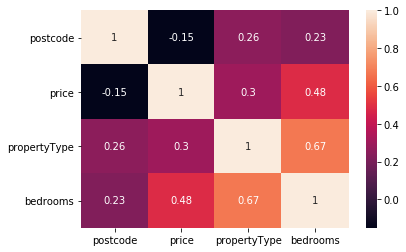

In [10]:
corr=df.corr()
sns.heatmap(corr,annot=True)

From heatmap and correlation matrix , it is shown that there is multicollinearity exists between independent variables

#### Printing column names

In [11]:
pd.Series(df.columns)

0        datesold
1        postcode
2           price
3    propertyType
4        bedrooms
dtype: object

#### Renaming the column Names

In [12]:
df.rename(columns={'datesold':'date','propertyType':'type'},inplace=True)
pd.Series(df.columns)

0        date
1    postcode
2       price
3        type
4    bedrooms
dtype: object

#### Checkin and setting up Index

In [13]:
print(df.index)
print()
print(df.set_index('date',inplace=True))
print()
print(type(df.index))

RangeIndex(start=0, stop=29580, step=1)

None

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


### Postal Code

#### Total House sold in each postal code

In [14]:
df_post=df.groupby(['postcode'])
df_post_count=df_post.count()
df_post_count['price'].sort_values()

postcode
2618       9
2609      10
2616      11
2620      26
2900     152
2911     249
2601     260
2912     499
2600     634
2606     659
2903     675
2605     771
2603     805
2904     919
2607     963
2902    1035
2604    1058
2614    1058
2612    1210
2906    1640
2611    1864
2914    1972
2617    2115
2905    2259
2913    2558
2602    2603
2615    3566
Name: price, dtype: int64

Text(0.5, 0, 'No of Houses')

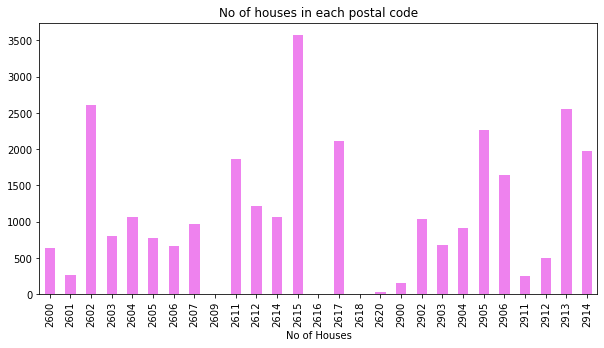

In [15]:
plt.figure(figsize=(10,5))
df_post_count['price'].plot(kind='bar',color='violet')
plt.title('No of houses in each postal code')
plt.xlabel('Postcode')
plt.xlabel('No of Houses')

#### Calculating total average on each postal code.

In [16]:
df_post_sum=df_post.mean()
df_post_sum['price'].sort_values()

postcode
2609    1.447000e+05
2620    2.872982e+05
2900    4.174579e+05
2616    4.492727e+05
2905    5.057797e+05
2615    5.062134e+05
2906    5.112580e+05
2912    5.219604e+05
2617    5.266716e+05
2601    5.404449e+05
2903    5.434755e+05
2902    5.444455e+05
2606    5.698613e+05
2913    5.894083e+05
2904    5.993130e+05
2614    6.091664e+05
2914    6.234308e+05
2611    6.421450e+05
2612    6.454111e+05
2604    6.476409e+05
2607    6.947164e+05
2602    6.957188e+05
2911    7.247956e+05
2605    7.861751e+05
2600    1.028204e+06
2603    1.028642e+06
2618    1.081111e+06
Name: price, dtype: float64

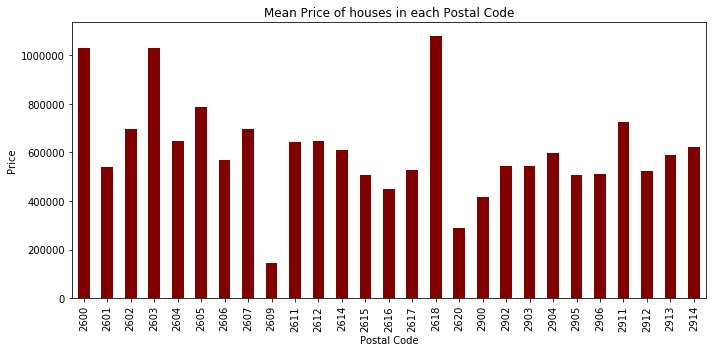

In [17]:
plt.figure(figsize=(10,5))
df_post_sum['price'].plot(kind='bar',color='maroon')
plt.xlabel('Postal Code')
plt.ylabel('Price')
plt.title('Mean Price of houses in each Postal Code')
plt.tight_layout()
plt.show()

#### Adding Year and Month columns

In [18]:
df.reset_index('date',inplace=True)
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df.sample(7)

,date,postcode,price,type,bedrooms,year,month
15618,2016-08-12,2913,610500,1,4,2016,8
3500,2011-02-23,2905,465000,1,3,2011,2
14806,2016-04-28,2914,780000,1,5,2016,4
12467,2015-08-15,2612,1362000,1,4,2015,8
22021,2018-06-02,2902,450000,1,3,2018,6
24773,2009-10-26,2617,317000,0,1,2009,10
17987,2017-04-12,2615,576000,1,3,2017,4


#### Total House sold on each day

In [19]:
df_date=df.groupby(['date'])
df_date_count=df_date.count()
df_date_count['price'].sort_values(ascending=False)

date
2017-10-28    50
2017-11-18    39
2018-03-24    38
2017-11-11    37
2017-04-08    37
              ..
2012-01-15     1
2012-01-21     1
2012-01-26     1
2012-02-25     1
2007-02-07     1
Name: price, Length: 3582, dtype: int64

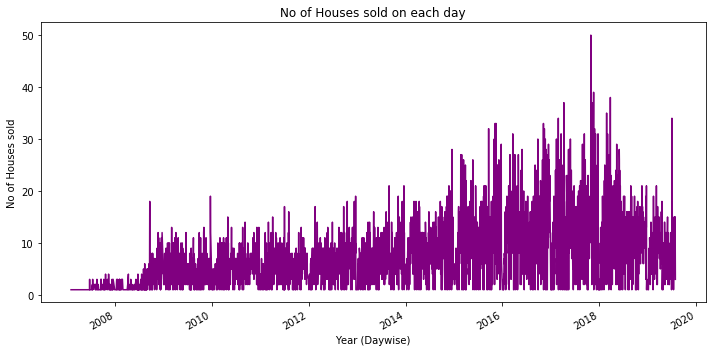

In [20]:
plt.figure(figsize=(10,5))
df_date_count['price'].sort_values(ascending=False).sort_values().plot(color='purple')
plt.xlabel('Year (Daywise)')
plt.ylabel('No of Houses sold')
plt.title('No of Houses sold on each day')
plt.tight_layout()
plt.show()

#### Total house sold on each month of the year

In [21]:
df_month=df.groupby(['year','month'])
df_month_count=df_month.count()
df_month_count['price']

year  month
2007  2          2
      3          3
      4          3
      5          2
      6          6
              ... 
2019  3        236
      4        212
      5        220
      6        126
      7        250
Name: price, Length: 150, dtype: int64

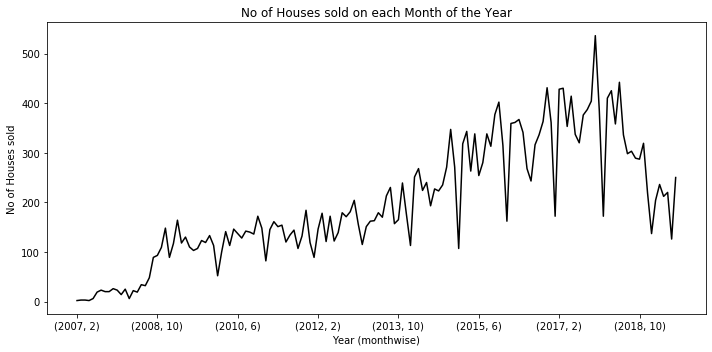

In [22]:
plt.figure(figsize=(10,5))
df_month_count['price'].plot(color='black')
plt.xlabel('Year (monthwise)')
plt.ylabel('No of Houses sold')
plt.title('No of Houses sold on each Month of the Year')
plt.tight_layout()
plt.show()

#### Total House sold on each year

In [23]:
df_year=df.groupby(['year'])
df_year_count=df_year.count()
df_year_count['price'].sort_values(ascending=False)

year
2017    4541
2016    3908
2018    3858
2015    3648
2014    2863
2013    2119
2012    1858
2011    1633
2010    1555
2009    1426
2019    1385
2008     639
2007     147
Name: price, dtype: int64

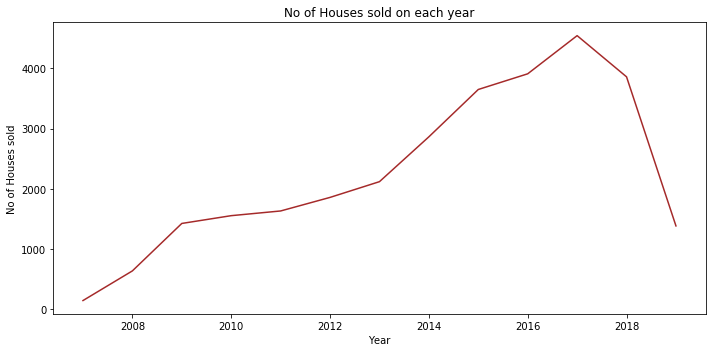

In [24]:
plt.figure(figsize=(10,5))
df_year_count['price'].plot(color='brown')
plt.xlabel('Year')
plt.ylabel('No of Houses sold')
plt.title('No of Houses sold on each year')
plt.tight_layout()
plt.show()

## Reframing the problem

Hence from this problem we could calculate the number of houses sold in each year. We could also predict the number of house that will be sold in future years

#### Extacting no of house sold in monthwise

In [25]:
hs_sales=df_month_count['price']
hs_sales.sample(7)

year  month
2008  6         34
2017  6        337
2009  11       133
2014  2        251
2018  11       319
2017  10       404
2013  6        170
Name: price, dtype: int64

#### Reframing the samples into dataframe

In [26]:
hs_sales=pd.DataFrame(hs_sales).reset_index()
hs_sales.rename(columns={'price':'house_sales'},inplace=True)

#### Printing the dataframe for house sales

In [27]:
hs_sales

,year,month,house_sales
0,2007,2,2
1,2007,3,3
2,2007,4,3
3,2007,5,2
4,2007,6,6
...,...,...,...
145,2019,3,236
146,2019,4,212
147,2019,5,220
148,2019,6,126


#### Creating separate year-month column

In [28]:
hs_sales['year-month']=hs_sales['year'].astype('str')+'-'+hs_sales['month'].astype('str')
hs_sales['year-month']=pd.to_datetime(hs_sales['year-month'])
hs_sales=hs_sales.drop(['year','month'],axis=1).set_index('year-month')
hs_sales

,house_sales
year-month,
2007-02-01,2
2007-03-01,3
2007-04-01,3
2007-05-01,2
2007-06-01,6
...,...
2019-03-01,236
2019-04-01,212
2019-05-01,220


#### Performing adfuller test to check the stationarity of the data

In [29]:
dftest = adfuller(hs_sales)
dftest
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is -1.846
DF test p-value is 0.3579


We failed to reject the Null Hypothesis. So, Data is not stationary.

#### Decomposing the dataframe

<Figure size 3600x2880 with 0 Axes>

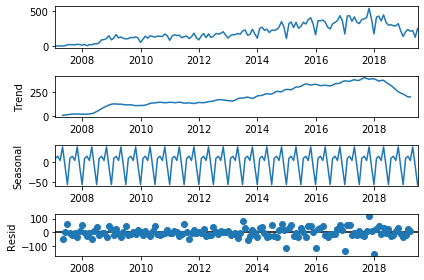

In [30]:
plt.figure(figsize=(50,40))
decomposition =seasonal_decompose(hs_sales,period=6)
decomposition.plot()
plt.show()

#### Differencing the data to 1 period to avoid stationarity

Text(0, 0.5, 'House Sales')

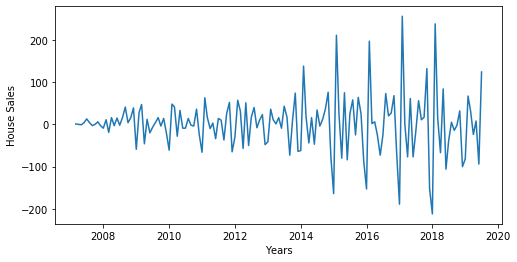

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(hs_sales.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('House Sales')

After differencing data plot seems to have lot of variance

#### Taking logarthm of dataframe

Text(0, 0.5, 'Log (House Sales)')

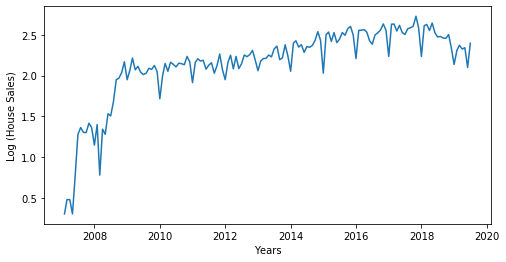

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(np.log10(hs_sales))
plt.xlabel('Years')
plt.ylabel('Log (House Sales)')

Now variance seems to be reduced and we could able to see the trend with small seasonal components 

#### Taking log and differencing the dataframe to 1 period

Text(0, 0.5, 'Differenced Log (Tractor Sales)')

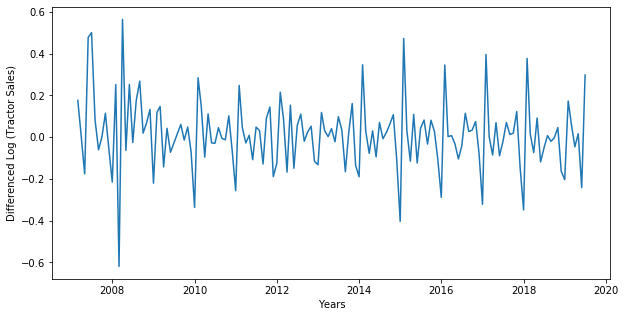

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(hs_sales).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

Now data looks good and with constant variance

### Checking Autocorrelation and Partial Autocorrelation for Non-Stationary data

In [34]:
hs_sales_log = np.log10(hs_sales)
hs_sales_log.dropna(inplace=True)

hs_sales_log_diff = hs_sales_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
hs_sales_log_diff.dropna(inplace=True)

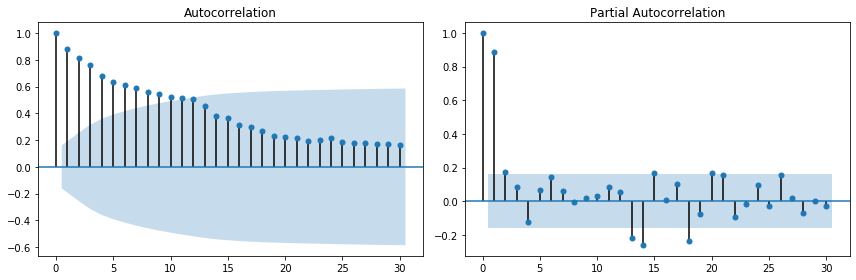

In [35]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(hs_sales_log, lags=30, ax=axes[0])
smt.graphics.plot_pacf(hs_sales_log, lags=30, ax=axes[1])
plt.tight_layout()

The above ACF is “decaying”, or decreasing, very slowly, and remains well above the significance range (blue band) for at least a dozen lags. This is indicative of a non-stationary series.

### Checking Autocorrelation and Partial Autocorrelation for Stationary data

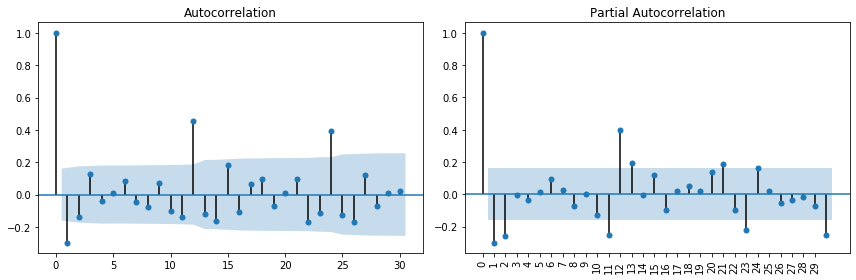

In [36]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(hs_sales_log_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(hs_sales_log_diff, lags=30, ax=axes[1])
plt.tight_layout()

The above ACF has “decayed” fast and remains within the significance range (blue band) except for a few (5) lags. This is indicative of a stationary series.

#### Decomposing the stationary data into separate components

<Figure size 3600x2880 with 0 Axes>

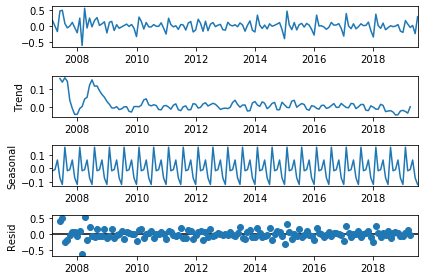

In [37]:
plt.figure(figsize=(50,40))
decomposition =seasonal_decompose(hs_sales_log_diff,period=6)
decomposition.plot()
plt.show()

#### Printing Trend Series

In [38]:
np.round(decomposition.trend.fillna(0),3)

year-month
2007-03-01    0.000
2007-04-01    0.000
2007-05-01    0.000
2007-06-01    0.157
2007-07-01    0.137
              ...  
2019-03-01   -0.033
2019-04-01    0.002
2019-05-01    0.000
2019-06-01    0.000
2019-07-01    0.000
Name: trend, Length: 149, dtype: float64

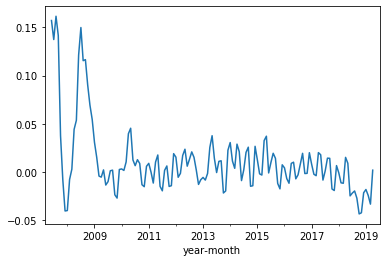

In [39]:
decomposition.trend.plot()

#### Printing Seasonal Series

In [40]:
np.round(decomposition.seasonal.fillna(0),3)

year-month
2007-03-01   -0.018
2007-04-01   -0.009
2007-05-01    0.061
2007-06-01   -0.070
2007-07-01   -0.118
              ...  
2019-03-01   -0.018
2019-04-01   -0.009
2019-05-01    0.061
2019-06-01   -0.070
2019-07-01   -0.118
Name: seasonal, Length: 149, dtype: float64

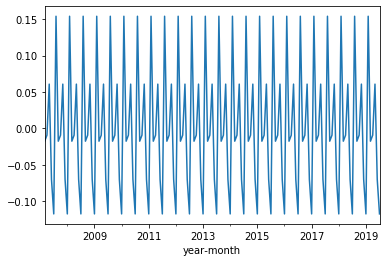

In [41]:
plt.plot(figsize=(50,10))
decomposition.seasonal.plot()
plt.show()

#### Printing Residual Series

In [42]:
np.round(decomposition.resid.fillna(0),3)

year-month
2007-03-01    0.000
2007-04-01    0.000
2007-05-01    0.000
2007-06-01    0.390
2007-07-01    0.481
              ...  
2019-03-01    0.114
2019-04-01   -0.039
2019-05-01    0.000
2019-06-01    0.000
2019-07-01    0.000
Name: resid, Length: 149, dtype: float64

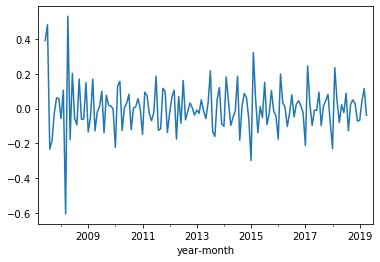

In [43]:
decomposition.resid.plot()

Now the variance of residuals is reduced and seasoanl variance seems to be changed.

### Building Model using - Rolling Average Technique 

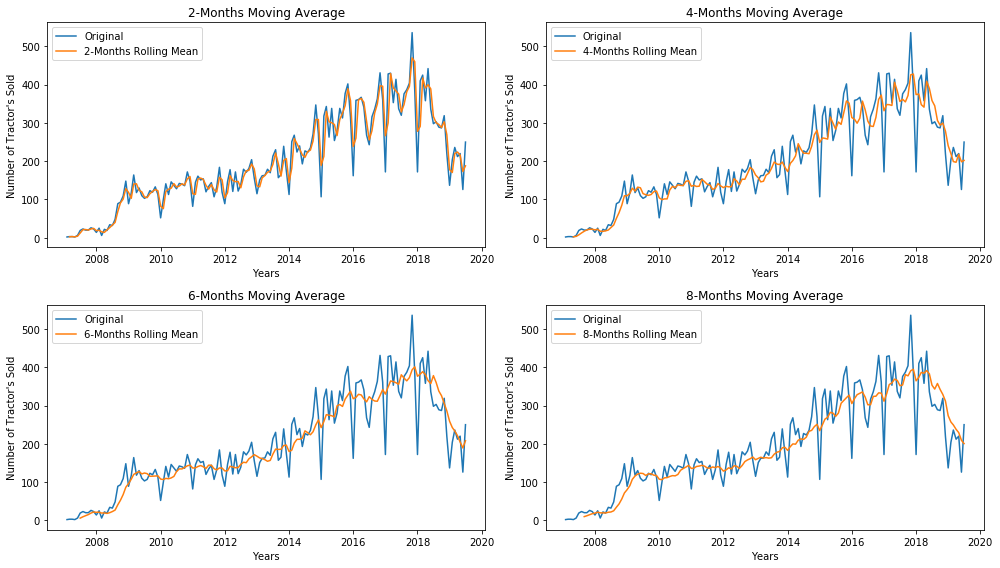

In [44]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(hs_sales.index, hs_sales, label='Original')
axes[0][0].plot(hs_sales.index, hs_sales.rolling(window=2).mean(), label='2-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("2-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(hs_sales.index, hs_sales, label='Original')
axes[0][1].plot(hs_sales.index, hs_sales.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("4-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(hs_sales.index, hs_sales, label='Original')
axes[1][0].plot(hs_sales.index, hs_sales.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("6-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(hs_sales.index, hs_sales, label='Original')
axes[1][1].plot(hs_sales.index, hs_sales.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("8-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

From the plots, It is shown that moving average peforms well with the window size of 2. So, we consider the windows size of 2 for this timeseries sequence

In [45]:
rolmean = hs_sales.rolling(window = 2).mean()
rolstd = hs_sales.rolling(window = 2).std()

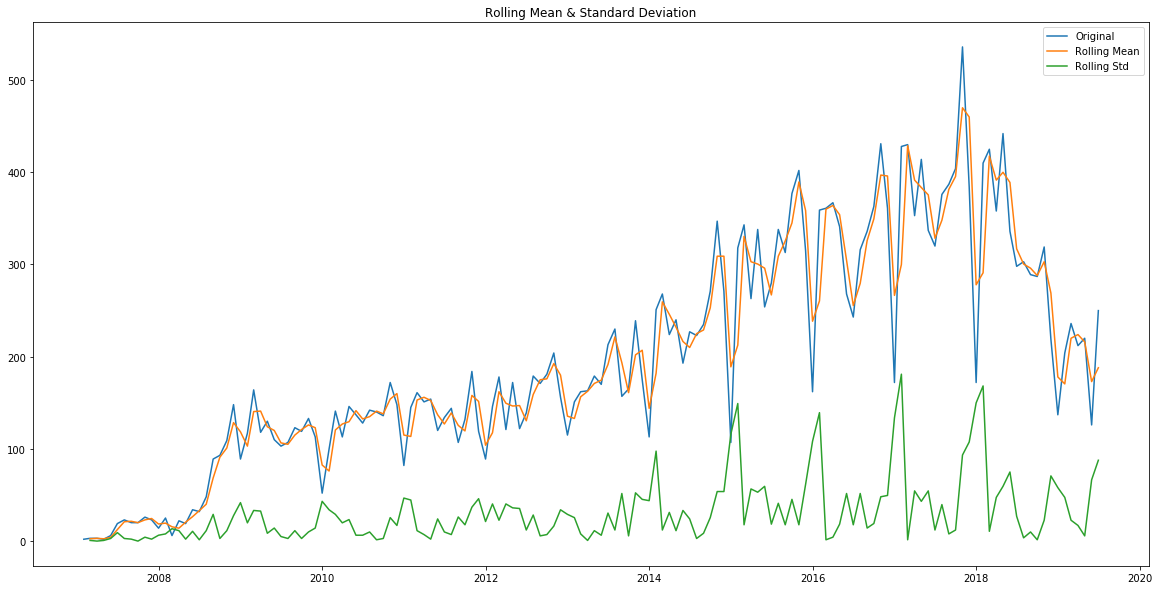

In [46]:
#Plot rolling statistics:
plt.figure(figsize=(20,10))
orig = plt.plot(hs_sales, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

## Building ARIMA model

In [47]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [48]:
print('PDQ :\n',pd.Series(pdq))
print()
print('SEASONAL_PDQ :\n',pd.Series(seasonal_pdq))

PDQ :
 0    (0, 0, 0)
1    (0, 0, 1)
2    (0, 1, 0)
3    (0, 1, 1)
4    (1, 0, 0)
5    (1, 0, 1)
6    (1, 1, 0)
7    (1, 1, 1)
dtype: object

SEASONAL_PDQ :
 0    (0, 0, 0, 12)
1    (0, 0, 1, 12)
2    (0, 1, 0, 12)
3    (0, 1, 1, 12)
4    (1, 0, 0, 12)
5    (1, 0, 1, 12)
6    (1, 1, 0, 12)
7    (1, 1, 1, 12)
dtype: object


### Splitting dataset into train and test

In [49]:
train = hs_sales[hs_sales.index < '2019-01-01']
test = hs_sales[hs_sales.index >= '2019-01-01']
train_hs_sales_log = np.log10(train['house_sales'])

In [50]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [51]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = SARIMAX(train_hs_sales_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True)
            results = temp_model.fit()

            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-166.61416268573115


### Predict sales on in-sample date using the best fit ARIMA model

In [52]:
### Building best model with best opted parameters
best_model = SARIMAX(train_hs_sales_log,order=(0, 1, 1),seasonal_order=(1, 0, 1, 12),enforce_stationarity=True)
best_results = best_model.fit()

In [53]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                        house_sales   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  87.307
Date:                            Tue, 14 Apr 2020   AIC                           -166.614
Time:                                    17:23:46   BIC                           -154.791
Sample:                                02-01-2007   HQIC                          -161.810
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3178      0.053     -6.042      0.000      -0.421      -0.215
ar.S.L12       0.9280      0.049   

#### Getting prediction results from 2019 and their confidence interval

In [54]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [55]:
pred_dynamic_ci

,lower house_sales,upper house_sales
2019-01-01,1.864741,2.361576


### Forecasting the house sales for year 2019

In [56]:
pred99 = best_results.get_forecast(steps=12, alpha=0.1)

In [57]:
# Extract the predicted and true values of our time series
hs_sales_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['house_sales_forecasted'] = np.power(10, pred99.predicted_mean)

In [58]:
testCopy

,house_sales,house_sales_forecasted
year-month,,
2019-01-01,137,129.765228
2019-02-01,204,256.593681
2019-03-01,236,263.954150
2019-04-01,212,233.552413
2019-05-01,220,262.757422
2019-06-01,126,217.315458
2019-07-01,250,210.487547


#### Evaluating the model using RMSE technique

In [59]:
# Compute the root mean square error
mse = ((testCopy['house_sales'] - testCopy['house_sales_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 47.498


### Plotting the Original data vs Test data vs Forecasted data

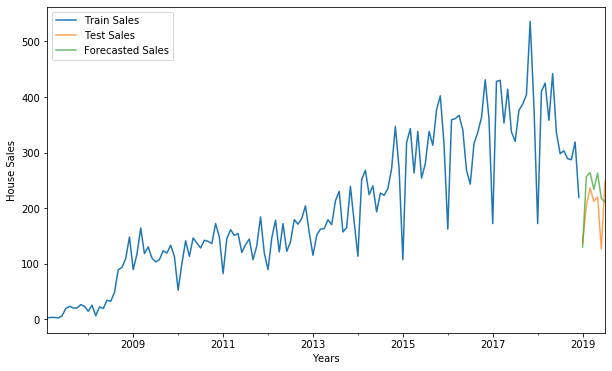

In [60]:
axis = train['house_sales'].plot(label='Train Sales', figsize=(10, 6))
testCopy['house_sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['house_sales_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('House Sales')
plt.legend(loc='best')
plt.show()
plt.close()

### Conclusion

- Therefore house sales for year 2019 is predicted well using ARIMA model.
- We have implemented the rolling average technique with window size 2 and peformed well.
- Every trend,seasonal and residual are shown clearly.
- This model predicted the output with RMSE(Root Mean Squate Error) of 47.5.
- EDA is done deeply through attribute wise and shown using plots.
- Preprocessing and Formatting has been carried out cleanly.